In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.layers.experimental import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

import inspect
import os
import sys
import math
import json

from data.feature_processing import get_category_encoding_layer, get_normalization_layer, split_train_test, prepare_data
from model.dl_models import exp1_model

# Preprocessing

In [2]:
WORKFOLDER = os.getcwd()


In [3]:
filepath = os.path.join(WORKFOLDER, os.path.join('dataset', 'sepsis_p1_prefix.csv'))
raw_df = pd.read_csv(filepath)
raw_df["label"] = raw_df["label"].astype(int)
# raw_df = raw_df.rename(columns={"case:concept:name": "CaseID", "time:timestamp": "Timestamps"}, errors="raise")
raw_df.index.name = "index"

In [4]:
log_df_train, log_df_test, log_df_val = split_train_test(raw_df, 0.3) # 70%/15%/15%

In [5]:
print('Distribution of cases in log_df_train \n')
print(log_df_train.groupby(['label'])['case:concept:name'].nunique())

Distribution of cases in log_df_train 

label
0    476
1     71
Name: case:concept:name, dtype: int64


In [6]:
print('Distribution of cases in log_df_test\n')
print(log_df_test.groupby(['label'])['case:concept:name'].nunique())

Distribution of cases in log_df_test

label
0    96
1    21
Name: case:concept:name, dtype: int64


In [7]:
print('Distribution of cases in log_df_test \n')
print(log_df_val.groupby(['label'])['case:concept:name'].nunique())

Distribution of cases in log_df_test 

label
0    102
1     15
Name: case:concept:name, dtype: int64


In [8]:
def normalize_events(log_df,features):

#log_df(DataFrame): The dataframe with eventlog data
#args(Dictionary): The set of parameters
#Returns a Dataframe with normalized numerical features
  for feature in features:
    logit = lambda x: math.log1p(x[feature])
    log_df['%s_log'%(feature)] = log_df.apply(logit, axis=1)
    mean_feature = np.mean(log_df['%s_log'%(feature)])
    std_feature=np.std(log_df['%s_log'%(feature)])
    norm = lambda x: (x['%s_log'%(feature)]-mean_feature)/std_feature
    log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
  return log_df

In [9]:
numerical_features = ['elapsed_time']
log_df_train = normalize_events(log_df_train, numerical_features)
log_df_test = normalize_events(log_df_test, numerical_features)
log_df_val = normalize_events(log_df_val, numerical_features)
log_df_train.head()

,case:concept:name,time:timestamp,concept:name,org:group,CRP,LacticAcid,Leucocytes,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,...,SIRSCritTemperature,SIRSCriteria2OrMore,Age,label,elapsed_time,prefix,k,res_list,elapsed_time_log,elapsed_time_norm
0,XJ,2013-11-07 07:18:29+00:00,ER Registration,A,NaN,NaN,NaN,C,False,True,...,True,True,90.0,0,0.000000,ER Registration,0.0,A,0.000000,-1.871709
1,XJ,2013-11-07 07:29:18+00:00,ER Triage,C,NaN,NaN,NaN,C,False,True,...,True,True,90.0,0,10.816667,ER Registration:||:ER Triage,1.0,A:||:C,2.469511,-1.082409
2,XJ,2013-11-07 07:37:32+00:00,ER Sepsis Triage,A,NaN,NaN,NaN,C,False,True,...,True,True,90.0,0,19.050000,ER Registration:||:ER Triage:||:ER Sepsis Triage,2.0,A:||:C:||:A,2.998229,-0.913421
3,XJ,2013-11-07 07:51:00+00:00,LacticAcid,B,NaN,1.4,NaN,C,False,True,...,True,True,90.0,0,32.516667,ER Registration:||:ER Triage:||:ER Sepsis Tria...,3.0,A:||:C:||:A:||:B,3.512043,-0.749197
4,XJ,2013-11-07 07:51:00+00:00,Leucocytes,B,NaN,NaN,296.2,C,False,True,...,True,True,90.0,0,32.516667,ER Registration:||:ER Triage:||:ER Sepsis Tria...,4.0,A:||:C:||:A:||:B:||:B,3.512043,-0.749197


In [10]:
with open(f"dataset/metadata.json", "r") as metadata_file:
    metadata = json.load(metadata_file)

act_word_dict = metadata["act_word_dict"]
res_word_dict = metadata["res_word_dict"]

max_case_length = int(max(raw_df["k"].values)+1)
act_vocab_size = int(len(act_word_dict))
res_vocab_size = int(len(res_word_dict))

train_token_act, train_token_res, train_token_label, train_token_t = prepare_data(log_df_train, act_word_dict, res_word_dict, max_case_length)
val_token_act, val_token_res, val_token_label, val_token_t = prepare_data(log_df_train, act_word_dict, res_word_dict, max_case_length)
test_token_act, test_token_res, test_token_label, test_token_t = prepare_data(log_df_train, act_word_dict, res_word_dict, max_case_length)

In [11]:
print(train_token_act.shape)
print(train_token_res.shape)
print(train_token_label.shape)
print(train_token_t.shape)

(9292, 185)
(9292, 185)
(9292,)
(9292,)


# Deep learning models

In [12]:
learning_rate = 0.001
batch_size = 256
epochs = 5

In [13]:
# Create and train a model
model = exp1_model(
        max_case_length=max_case_length, act_vocab_size=act_vocab_size, res_vocab_size=res_vocab_size)

model.compile(optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)],
        loss='binary_crossentropy')

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=2,
                                verbose=1,
                                mode='auto',
                                min_delta=0.0001,
                                cooldown=0,
                                min_lr=0)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)

histroy = model.fit([train_token_act,train_token_res, train_token_t],
        train_token_label,
        validation_data=([val_token_act,val_token_res, val_token_t], val_token_label),
        verbose=1,
        callbacks=[early_stopping, lr_reducer],
        batch_size = batch_size,
        epochs = epochs)

Epoch 1/5
37/37 [==============================] - 14s 252ms/step - loss: 0.5180 - accuracy: 0.7640 - auc: 0.6901 - val_loss: 0.4112 - val_accuracy: 0.8416 - val_auc: 0.7734
Epoch 2/5
37/37 [==============================] - 7s 198ms/step - loss: 0.3868 - accuracy: 0.8504 - auc: 0.8029 - val_loss: 0.3375 - val_accuracy: 0.8752 - val_auc: 0.8528
Epoch 3/5
37/37 [==============================] - 4s 106ms/step - loss: 0.2797 - accuracy: 0.9036 - auc: 0.8856 - val_loss: 0.2466 - val_accuracy: 0.9191 - val_auc: 0.9103
Epoch 4/5
37/37 [==============================] - 4s 99ms/step - loss: 0.2308 - accuracy: 0.9259 - auc: 0.9126 - val_loss: 0.2212 - val_accuracy: 0.9321 - val_auc: 0.9157
Epoch 5/5
37/37 [==============================] - 4s 106ms/step - loss: 0.2182 - accuracy: 0.9320 - auc: 0.9180 - val_loss: 0.2134 - val_accuracy: 0.9330 - val_auc: 0.9211


In [14]:
def print_learning_curves(history1, model_type):
  # list all data in history
  print(history1.history.keys())
  # summarize history for accuracy
  plt.plot(history1.history['accuracy'])
  plt.plot(history1.history['val_accuracy'])
  plt.title('model accuracy  (' + model_type + ')')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history1.history['loss'])
  plt.plot(history1.history['val_loss'])
  plt.title('model loss (' + model_type + ')')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])


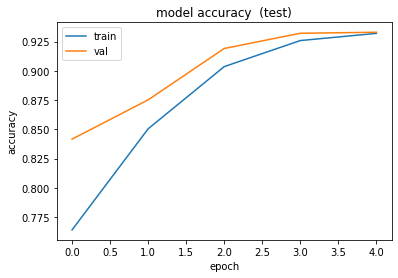

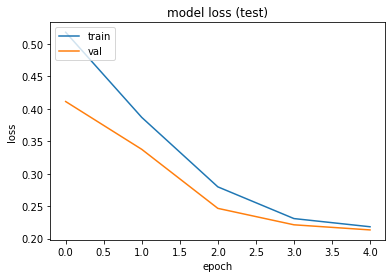

In [15]:
print_learning_curves(histroy, "test")

In [16]:
def evaluate_model(inputs, test_token_label, model1):

  # Evaluate the model on the test data using `evaluate`
  print("Evaluate on test data")
  results = model1.evaluate(inputs, test_token_label, batch_size=5)# fix the padding size to be common for both test and train
  print("test loss, test acc:", results)

  #Prediction

  y_pred = model1.predict(inputs)
  return y_pred, test_token_label, inputs

In [17]:
y_pred, y_test, x_test = evaluate_model([test_token_act, test_token_res, test_token_t], test_token_label, model)

Evaluate on test data
1859/1859 [==============================] - 41s 22ms/step - loss: 0.2134 - accuracy: 0.9330 - auc: 0.9211
test loss, test acc: [0.21335402131080627, 0.9329530596733093, 0.9210553765296936]
